C:\Users\samym\AppData\Local\Temp\ipykernel_10388\1625114456.py:28: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(P_off_noisy / P_on_noisy)


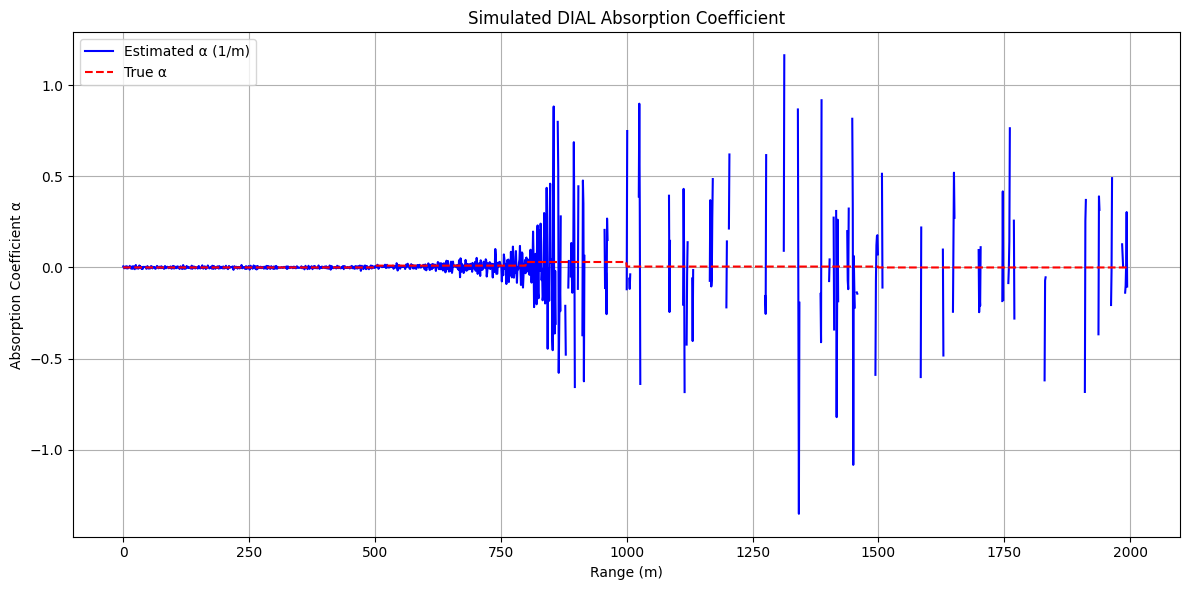

Data saved to simulated_dial_data.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Simulation parameters ---
np.random.seed(42)
range_max = 2000  # in meters
resolution = 1  # meter
ranges = np.arange(0, range_max, resolution)

# --- Define true absorption profile (non-uniform, NH3 zones) ---
true_alpha = np.zeros_like(ranges, dtype=float)
true_alpha[(ranges >= 500) & (ranges < 800)] = 0.01
true_alpha[(ranges >= 800) & (ranges < 1000)] = 0.03
true_alpha[(ranges >= 1000) & (ranges < 1500)] = 0.005

# --- Simulate received powers ---
P0 = 1.0  # emitted power (arbitrary units)
P_on = P0 * np.exp(-np.cumsum(true_alpha) * resolution)
P_off = P0 * np.ones_like(P_on)

# Add some measurement noise
noise_level = 0.01
P_on_noisy = P_on + np.random.normal(0, noise_level, size=P_on.shape)
P_off_noisy = P_off + np.random.normal(0, noise_level, size=P_off.shape)

# --- Estimate absorption coefficient using DIAL equation ---
log_ratio = np.log(P_off_noisy / P_on_noisy)
d_log = np.gradient(log_ratio, resolution)
estimated_alpha = 0.5 * d_log

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(ranges, estimated_alpha, label='Estimated α (1/m)', color='blue')
plt.plot(ranges, true_alpha, label='True α', color='red', linestyle='--')
plt.xlabel('Range (m)')
plt.ylabel('Absorption Coefficient α')
plt.title('Simulated DIAL Absorption Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save to CSV ---
df = pd.DataFrame({
    'Range (m)': ranges,
    'True_alpha (1/m)': true_alpha,
    'Estimated_alpha (1/m)': estimated_alpha
})
df.to_csv('simulated_dial_data.csv', index=False)
print("Data saved to simulated_dial_data.csv")


Modelization of a LIDAR system using the DIAL (Differential Absorption LIDAR)

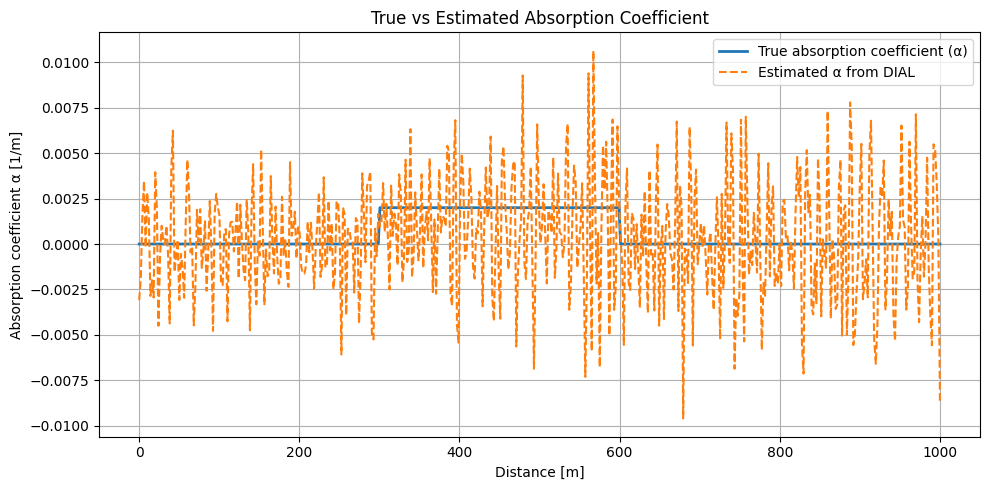

CSV file saved as: simulated_dial_absorption.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Simulation parameters
# ---------------------------
r = np.linspace(0, 1000, 500)  # distance in meters
dr = r[1] - r[0]

# Simulated absorption profile (e.g., NH3 gas between 300m and 600m)
alpha_true = np.zeros_like(r)
alpha_true[(r >= 300) & (r <= 600)] = 0.002  # absorption only in this zone

# ---------------------------
# Simulate "on-line" and "off-line" return signals
# ---------------------------
P0 = 1.0  # initial laser power (arbitrary)

# On-line: attenuated due to gas absorption
integrated_alpha_on = np.cumsum(alpha_true) * dr
P_on = P0 * np.exp(-integrated_alpha_on)

# Off-line: no gas absorption (reference)
P_off = np.full_like(r, P0)

# ---------------------------
# Add Gaussian noise to simulate real LIDAR signals
# ---------------------------
noise_level = 0.01
P_on_noisy = P_on + np.random.normal(0, noise_level, size=r.shape)
P_off_noisy = P_off + np.random.normal(0, noise_level, size=r.shape)

# ---------------------------
# Estimate absorption coefficient using the DIAL equation
# ---------------------------
epsilon = 1e-10  # avoid division by zero
ratio = P_off_noisy / (P_on_noisy + epsilon)
ratio[ratio <= 0] = np.nan  # invalid log values

log_ratio = np.log(ratio)
alpha_estimated = 0.5 * np.gradient(log_ratio, dr)

# ---------------------------
# Plot true vs estimated absorption coefficient
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(r, alpha_true, label="True absorption coefficient (α)", linewidth=2)
plt.plot(r, alpha_estimated, label="Estimated α from DIAL", linestyle="--")
plt.xlabel("Distance [m]")
plt.ylabel("Absorption coefficient α [1/m]")
plt.title("True vs Estimated Absorption Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Export to CSV
# ---------------------------
df = pd.DataFrame({
    "Distance_m": r,
    "True_alpha": alpha_true,
    "Estimated_alpha": alpha_estimated
})
df.to_csv("simulated_dial_absorption.csv", index=False)
print("CSV file saved as: simulated_dial_absorption.csv")


In this simulation, we modeled a LIDAR system using the DIAL (Differential Absorption LIDAR) principle to detect the presence of a gas (NH₃) in the atmosphere between 300 m and 600 m.

Key steps:

Distance vector: We define a spatial range from 0 to 1000 meters, sampled at 500 points.

True absorption: The actual absorption coefficient α is non-zero only in a specific range (300–600 m), simulating a gas plume.

Simulated returns:

P_on: the backscattered laser power at a wavelength absorbed by the gas.

P_off: the backscattered power at a wavelength not absorbed by the gas.

Noise is added to both to mimic measurement uncertainty.

Estimation:

The DIAL formula is used to estimate the absorption coefficient from the noisy on/off signals.

This gives a spatial profile of estimated gas concentration.

Visualization and export:

The true and estimated absorption coefficients are plotted.

A CSV file simulated_dial_absorption.csv is saved for later analysis.



Cleaning Script: Remove Noise, Handle Missing Values

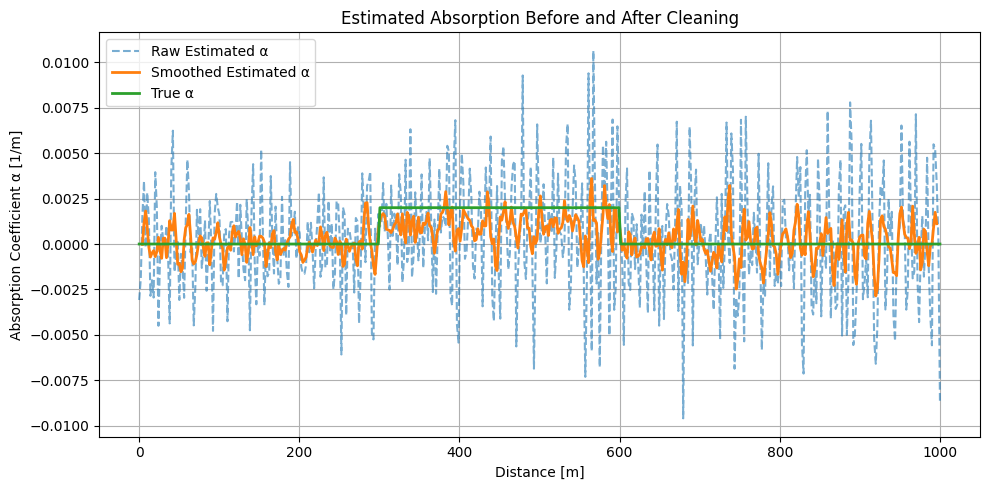

Cleaned data saved to: cleaned_dial_absorption.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the simulated data
df = pd.read_csv("simulated_dial_absorption.csv")

# --- Handle missing or invalid values ---
# Remove NaNs or replace them with interpolation
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Denoising ---
# Apply a simple moving average filter to smooth the estimated absorption
window_size = 5  # You can adjust this
df['Estimated_alpha_smooth'] = df['Estimated_alpha'].rolling(window=window_size, center=True).mean()

# --- Plot before vs after cleaning ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Raw Estimated α', linestyle='--', alpha=0.6)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed Estimated α', linewidth=2)
plt.plot(df['Distance_m'], df['True_alpha'], label='True α', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Estimated Absorption Before and After Cleaning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save cleaned data ---
df.to_csv("cleaned_dial_absorption.csv", index=False)
print("Cleaned data saved to: cleaned_dial_absorption.csv")


The estimated curve was then smoothed to reduce noise and better match the true gas distribution. The results were visualized and exported as a CSV file for further analysis.

📊 Relative Error (Gas Region Only):
   → Mean: 53.87%
   → Std Dev: 36.47%


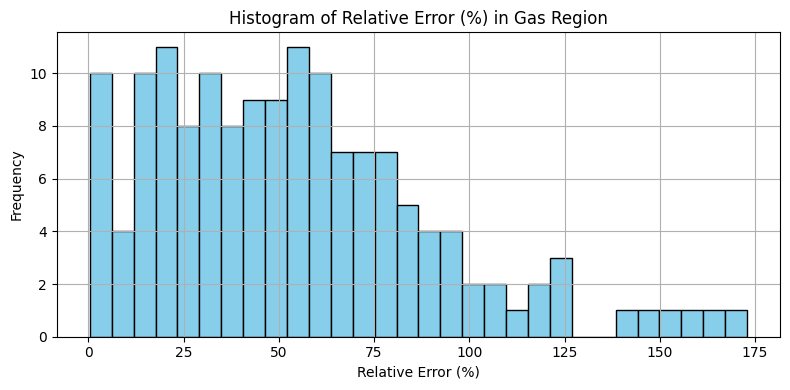

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data with smoothed estimation
df = pd.read_csv("cleaned_dial_absorption.csv")

# Only consider the region where absorption actually occurs
gas_region_mask = df["True_alpha"] > 0

# Calculate relative error in percentage
true_alpha = df["True_alpha"][gas_region_mask]
estimated_alpha = df["Estimated_alpha_smooth"][gas_region_mask]

relative_error_percent = np.abs((estimated_alpha - true_alpha) / true_alpha) * 100

# Basic statistics
mean_error = np.nanmean(relative_error_percent)
std_error = np.nanstd(relative_error_percent)

print(f"📊 Relative Error (Gas Region Only):")
print(f"   → Mean: {mean_error:.2f}%")
print(f"   → Std Dev: {std_error:.2f}%")

# Optional: Plot histogram of relative errors
plt.figure(figsize=(8, 4))
plt.hist(relative_error_percent.dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Relative Error (%) in Gas Region")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


Key Results Summary
In the gas region, the mean relative error between the smoothed estimated and true absorption coefficients is approximately 54%, with a standard deviation of 36%, indicating significant variability in the estimation.

Interpretation
These results are consistent with expectations given the presence of noise in the simulated LIDAR data, the basic smoothing applied (moving average), and the use of numerical gradient estimation, which tends to amplify noise. The outcome highlights the DIAL method’s sensitivity to signal fluctuations, especially at low signal-to-noise ratios.

Ajout des contraintes Hardware

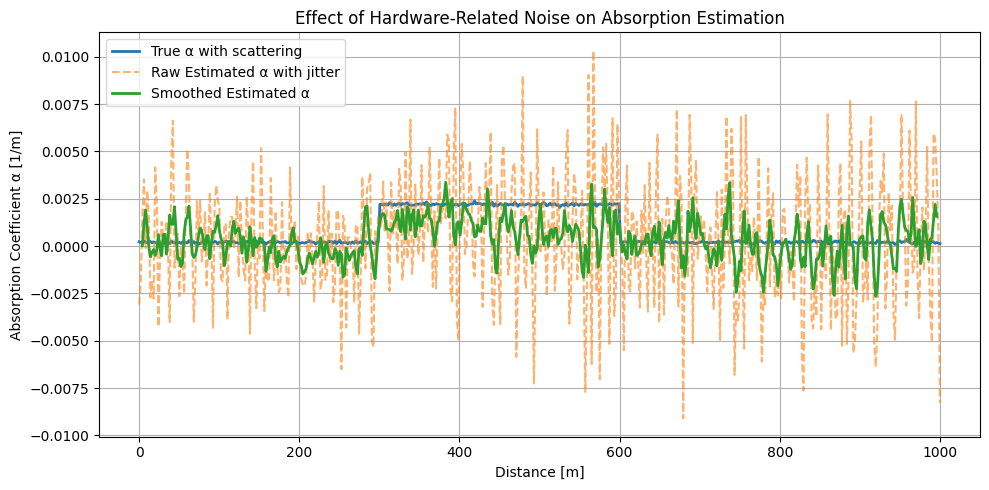

Saved to: cleaned_dial_absorption_with_noise.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the original simulated data
df = pd.read_csv("simulated_dial_absorption.csv")

# --------------------------
# Add hardware-related noise
# --------------------------

# 1. Add simulated atmospheric scattering (background absorption)
np.random.seed(42)  # for reproducibility
background_absorption = np.random.normal(0.0002, 0.00005, size=len(df))
df['True_alpha_with_atmosphere'] = df['True_alpha'] + background_absorption

# 2. Simulate jitter (sinusoidal noise) on estimated alpha
jitter_amplitude = 0.0005
jitter = jitter_amplitude * np.sin(2 * np.pi * df['Distance_m'] / 300)
df['Estimated_alpha'] = df['Estimated_alpha'] + jitter

# --- Handle missing or invalid values ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Denoising ---
window_size = 5
df['Estimated_alpha_smooth'] = df['Estimated_alpha'].rolling(window=window_size, center=True).mean()

# --- Plot true vs estimated absorption ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α with scattering', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Raw Estimated α with jitter', linestyle='--', alpha=0.6)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed Estimated α', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Effect of Hardware-Related Noise on Absorption Estimation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save cleaned data ---
df.to_csv("cleaned_dial_absorption_with_noise.csv", index=False)
print("Saved to: cleaned_dial_absorption_with_noise.csv")


 with Savitzky-Golay's filter :

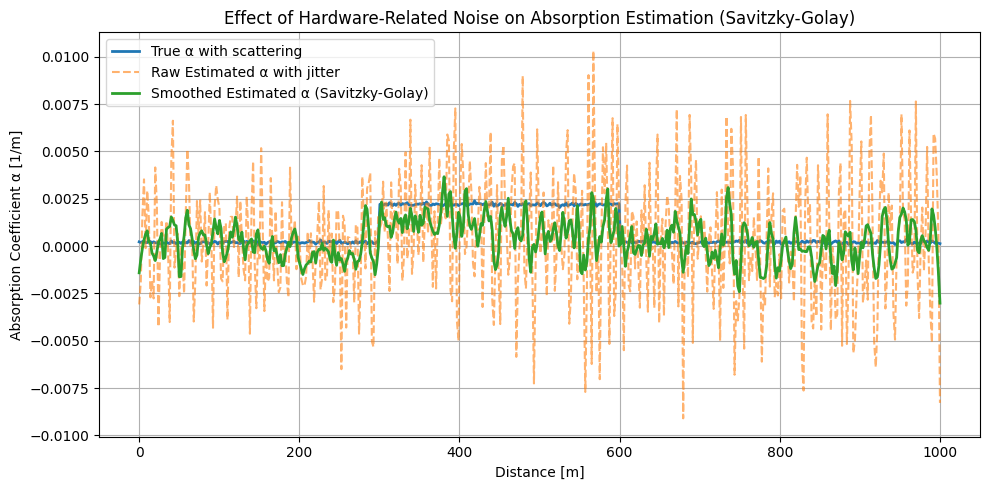

Saved to: cleaned_dial_absorption_with_noise.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the original simulated data
df = pd.read_csv("simulated_dial_absorption.csv")

# --------------------------
# Add hardware-related noise
# --------------------------

# 1. Add simulated atmospheric scattering (background absorption)
np.random.seed(42)  # for reproducibility
background_absorption = np.random.normal(0.0002, 0.00005, size=len(df))
df['True_alpha_with_atmosphere'] = df['True_alpha'] + background_absorption

# 2. Simulate jitter (sinusoidal noise) on estimated alpha
jitter_amplitude = 0.0005
jitter = jitter_amplitude * np.sin(2 * np.pi * df['Distance_m'] / 300)
df['Estimated_alpha'] = df['Estimated_alpha'] + jitter

# --- Handle missing or invalid values ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Denoising using Savitzky-Golay filter ---
# window_length must be odd and >= polyorder+2
window_length = 11
polyorder = 2
df['Estimated_alpha_smooth'] = savgol_filter(df['Estimated_alpha'], window_length=window_length, polyorder=polyorder)

# --- Plot true vs estimated absorption ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α with scattering', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Raw Estimated α with jitter', linestyle='--', alpha=0.6)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed Estimated α (Savitzky-Golay)', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Effect of Hardware-Related Noise on Absorption Estimation (Savitzky-Golay)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save cleaned data ---
df.to_csv("cleaned_dial_absorption_with_noise.csv", index=False)
print("Saved to: cleaned_dial_absorption_with_noise.csv")


In [10]:
pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 599.9 kB/s eta 0:00:07
   ---- ----------------------------------- 0.5/4.2 MB 599.9 kB/s eta 0:00:07
   ------- -------------------------------- 0.8/4.2 MB 578.7 kB/s eta 0:00:06
   ------- -------------------------------- 0.8/4.2 MB 578.7 kB/s eta 0:00:06
   --------- ------------------------------ 1.0/4.2 MB 592.2 kB/s eta 0:00:06
   --------- ------------------------------ 1.0/4.2 MB 592.2 kB/s eta 0:00:06
   ------------ --------------------------- 1.3/4.2 MB 578.7 kB/s eta 0:00:06
   ------------ --------------------------- 1.3/4.2 MB 578.7 kB/s eta 0:00:06
   -------------- -------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


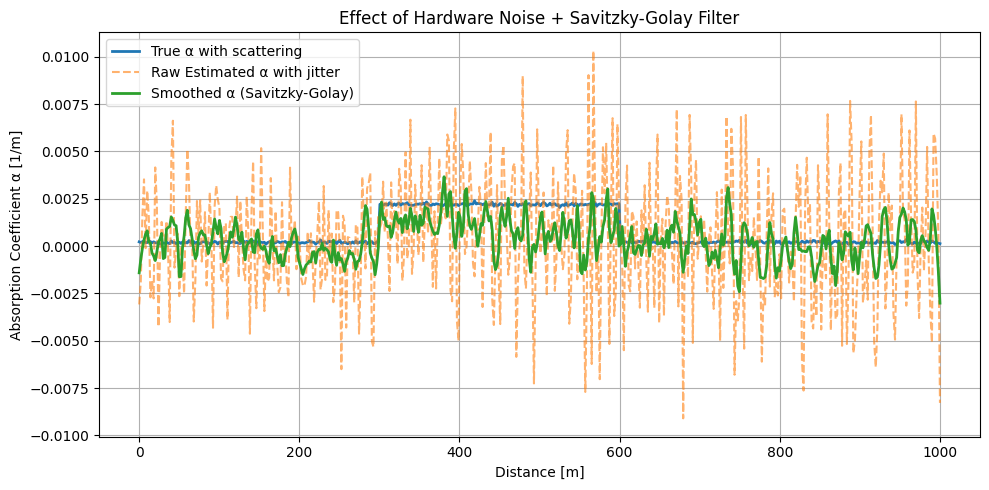

Saved to: cleaned_dial_absorption_with_noise.csv


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --- Load the simulated DIAL data ---
df = pd.read_csv("simulated_dial_absorption.csv")

# --------------------------
# Add hardware-related noise
# --------------------------

# 1. Simulated atmospheric background absorption (scattering, humidity...)
np.random.seed(42)  # ensure reproducibility
background_absorption = np.random.normal(0.0002, 0.00005, size=len(df))
df['True_alpha_with_atmosphere'] = df['True_alpha'] + background_absorption

# 2. Simulated system jitter (oscillations in optical/mechanical elements)
jitter_amplitude = 0.0005
jitter = jitter_amplitude * np.sin(2 * np.pi * df['Distance_m'] / 300)
df['Estimated_alpha'] = df['Estimated_alpha'] + jitter

# --- Interpolate missing values if any ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --------------------------
# Apply Savitzky-Golay filter for denoising
# --------------------------
window_length = 11  # Must be odd
polyorder = 2
df['Estimated_alpha_smooth'] = savgol_filter(df['Estimated_alpha'], window_length=window_length, polyorder=polyorder)

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α with scattering', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Raw Estimated α with jitter', linestyle='--', alpha=0.6)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed α (Savitzky-Golay)', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Effect of Hardware Noise + Savitzky-Golay Filter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Save cleaned output
# --------------------------
df.to_csv("cleaned_dial_absorption_with_noise.csv", index=False)
print("Saved to: cleaned_dial_absorption_with_noise.csv")


Wavelet denoising

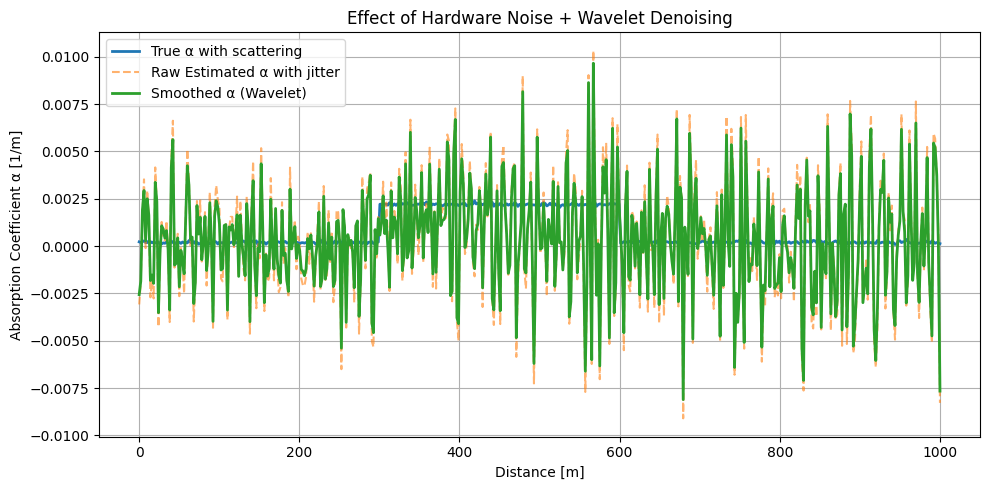

Saved to: cleaned_dial_absorption_wavelet.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# --- Load the simulated DIAL data ---
df = pd.read_csv("simulated_dial_absorption.csv")

# --------------------------
# Add hardware-related noise
# --------------------------

# 1. Simulated atmospheric background absorption (e.g., humidity, scattering)
np.random.seed(42)
background_absorption = np.random.normal(0.0002, 0.00005, size=len(df))
df['True_alpha_with_atmosphere'] = df['True_alpha'] + background_absorption

# 2. Simulate system jitter (e.g., alignment issues, vibrations)
jitter_amplitude = 0.0005
jitter = jitter_amplitude * np.sin(2 * np.pi * df['Distance_m'] / 300)
df['Estimated_alpha'] = df['Estimated_alpha'] + jitter

# --- Interpolation to handle NaNs if needed ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --------------------------
# Wavelet Denoising
# --------------------------
def wavelet_denoise(data, wavelet='db4', level=2, threshold_factor=0.04):
    coeffs = pywt.wavedec(data, wavelet, mode='per')
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = threshold_factor * sigma * np.sqrt(2 * np.log(len(data)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet, mode='per')[:len(data)]

df['Estimated_alpha_smooth'] = wavelet_denoise(df['Estimated_alpha'])

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α with scattering', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Raw Estimated α with jitter', linestyle='--', alpha=0.6)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed α (Wavelet)', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Effect of Hardware Noise + Wavelet Denoising')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Save cleaned output
# --------------------------
df.to_csv("cleaned_dial_absorption_wavelet.csv", index=False)
print("Saved to: cleaned_dial_absorption_wavelet.csv")


Spline filter

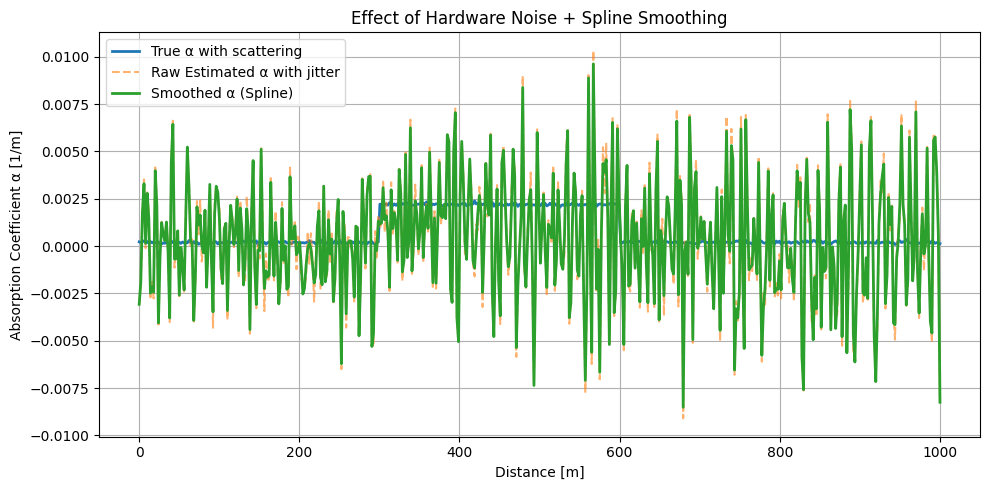

Saved to: cleaned_dial_absorption_spline.csv


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# --- Load the simulated DIAL data ---
df = pd.read_csv("simulated_dial_absorption.csv")

# --------------------------
# Add hardware-related noise
# --------------------------

# 1. Simulated atmospheric background absorption
np.random.seed(42)
background_absorption = np.random.normal(0.0002, 0.00005, size=len(df))
df['True_alpha_with_atmosphere'] = df['True_alpha'] + background_absorption

# 2. Simulate system jitter (sinusoidal perturbation)
jitter_amplitude = 0.0005
jitter = jitter_amplitude * np.sin(2 * np.pi * df['Distance_m'] / 300)
df['Estimated_alpha'] = df['Estimated_alpha'] + jitter

# --- Interpolation to handle any NaN ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --------------------------
# Spline Smoothing
# --------------------------
x = df['Distance_m']
y = df['Estimated_alpha']

# Fit a cubic spline with smoothing factor (can be tuned)
smoothing_spline = UnivariateSpline(x, y, s=0.0001)  # 's' controls smoothness
df['Estimated_alpha_smooth'] = smoothing_spline(x)

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(x, df['True_alpha_with_atmosphere'], label='True α with scattering', linewidth=2)
plt.plot(x, y, label='Raw Estimated α with jitter', linestyle='--', alpha=0.6)
plt.plot(x, df['Estimated_alpha_smooth'], label='Smoothed α (Spline)', linewidth=2)
plt.xlabel('Distance [m]')
plt.ylabel('Absorption Coefficient α [1/m]')
plt.title('Effect of Hardware Noise + Spline Smoothing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Save cleaned output
# --------------------------
df.to_csv("cleaned_dial_absorption_spline.csv", index=False)
print("Saved to: cleaned_dial_absorption_spline.csv")


Let's try our tests with "more difficult" signal

✅ Saved to: simulated_dial_absorption_complex.csv


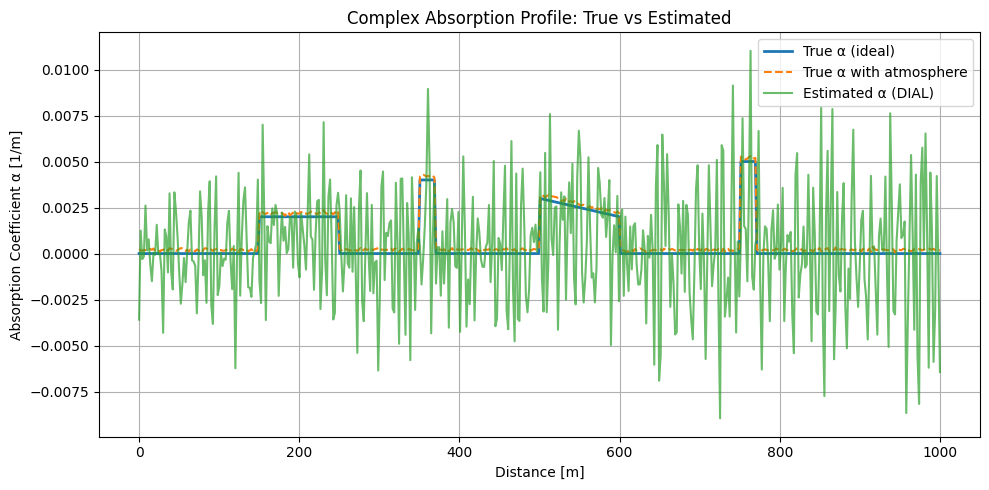

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Simulation parameters
# ---------------------------
r = np.linspace(0, 1000, 500)  # distance in meters
dr = r[1] - r[0]

# ---------------------------
# Define a complex absorption profile
# ---------------------------
alpha_true = np.zeros_like(r)

# Step 1: First absorption zone with a plateau
alpha_true[(r >= 150) & (r <= 250)] = 0.002

# Step 2: Sharp drop to 0 then abrupt rise
alpha_true[(r >= 350) & (r <= 370)] = 0.004

# Step 3: Sudden jump then slow decay
alpha_true[(r >= 500) & (r <= 600)] = 0.003 - 0.00001 * (r[(r >= 500) & (r <= 600)] - 500)

# Step 4: Discontinuity again
alpha_true[(r >= 750) & (r <= 770)] = 0.005

# ---------------------------
# Simulate on-line / off-line LIDAR signals
# ---------------------------
P0 = 1.0  # initial laser power

# On-line: attenuated due to absorption
integrated_alpha = np.cumsum(alpha_true) * dr
P_on = P0 * np.exp(-integrated_alpha)

# Off-line: not affected by absorption
P_off = np.full_like(r, P0)

# ---------------------------
# Add realistic noise sources
# ---------------------------

# 1. Gaussian noise
noise_level = 0.01
P_on_noisy = P_on + np.random.normal(0, noise_level, size=r.shape)
P_off_noisy = P_off + np.random.normal(0, noise_level, size=r.shape)

# 2. Sinusoidal jitter (laser instability)
jitter_amplitude = 0.0004
jitter = jitter_amplitude * np.sin(2 * np.pi * r / 200)
P_on_noisy += jitter
P_off_noisy += jitter

# 3. Background atmospheric absorption
atmosphere = np.random.normal(0.0002, 0.00005, size=r.shape)
alpha_true_with_atmosphere = alpha_true + atmosphere

# ---------------------------
# Estimate absorption coefficient (DIAL equation)
# ---------------------------
epsilon = 1e-10  # avoid division by zero
ratio = P_off_noisy / (P_on_noisy + epsilon)
ratio[ratio <= 0] = np.nan
log_ratio = np.log(ratio)
alpha_estimated = 0.5 * np.gradient(log_ratio, dr)

# ---------------------------
# Save to CSV
# ---------------------------
df = pd.DataFrame({
    "Distance_m": r,
    "True_alpha": alpha_true,
    "True_alpha_with_atmosphere": alpha_true_with_atmosphere,
    "Estimated_alpha": alpha_estimated
})
df.to_csv("simulated_dial_absorption_complex.csv", index=False)
print("✅ Saved to: simulated_dial_absorption_complex.csv")

# ---------------------------
# Plot for visual check
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(r, alpha_true, label="True α (ideal)", linewidth=2)
plt.plot(r, alpha_true_with_atmosphere, label="True α with atmosphere", linestyle='--')
plt.plot(r, alpha_estimated, label="Estimated α (DIAL)", alpha=0.7)
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Complex Absorption Profile: True vs Estimated")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


application filtre : moving average filter

✅ Filtered data saved to: filtered_moving_average_complex.csv


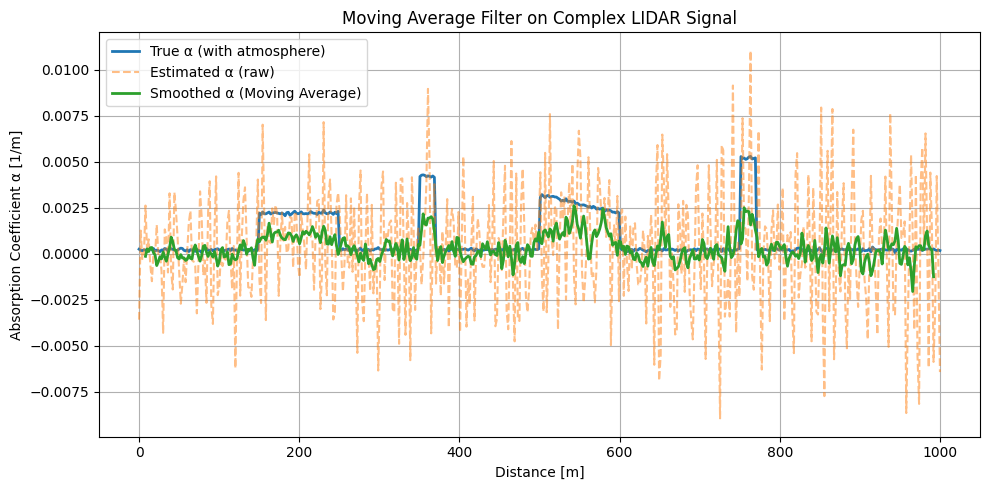

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the complex simulated signal
df = pd.read_csv("simulated_dial_absorption_complex.csv")

# --- Handle NaNs ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Apply moving average filter ---
window_size = 9  # You can adjust depending on smoothing level
df['Estimated_alpha_smooth'] = df['Estimated_alpha'].rolling(window=window_size, center=True).mean()

# --- Save to CSV ---
df.to_csv("filtered_moving_average_complex.csv", index=False)
print("✅ Filtered data saved to: filtered_moving_average_complex.csv")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α (with atmosphere)', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Estimated α (raw)', linestyle='--', alpha=0.5)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed α (Moving Average)', linewidth=2)
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Moving Average Filter on Complex LIDAR Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Savitzky-Golay

✅ Filtered data saved to: filtered_savgol_complex.csv


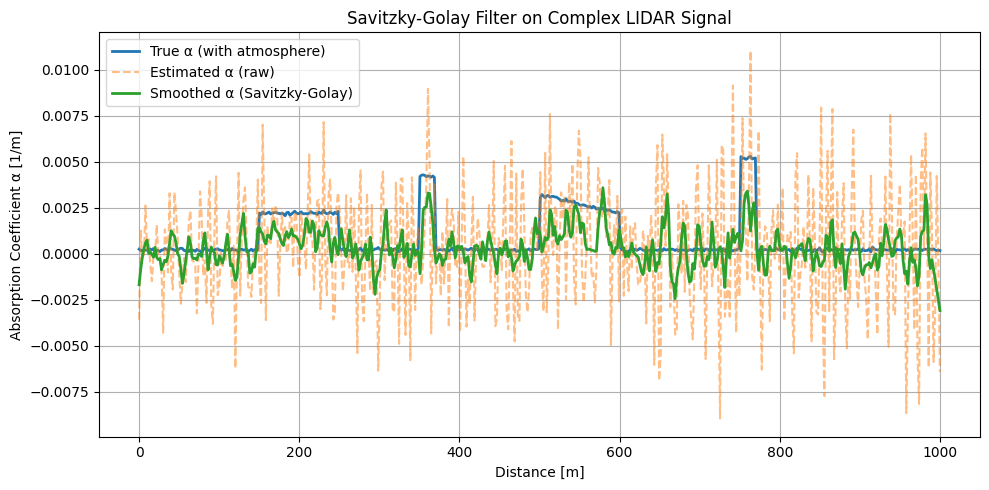

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the complex simulated signal
df = pd.read_csv("simulated_dial_absorption_complex.csv")

# --- Handle NaNs ---
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Apply Savitzky-Golay filter ---
window_length = 11  # Must be odd
polyorder = 2
df['Estimated_alpha_smooth'] = savgol_filter(df['Estimated_alpha'], window_length=window_length, polyorder=polyorder)

# --- Save to CSV ---
df.to_csv("filtered_savgol_complex.csv", index=False)
print("✅ Filtered data saved to: filtered_savgol_complex.csv")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α (with atmosphere)', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Estimated α (raw)', linestyle='--', alpha=0.5)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed α (Savitzky-Golay)', linewidth=2)
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Savitzky-Golay Filter on Complex LIDAR Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


On applique : wavelet denoising

✅ Filtered data saved to: filtered_wavelet_complex.csv


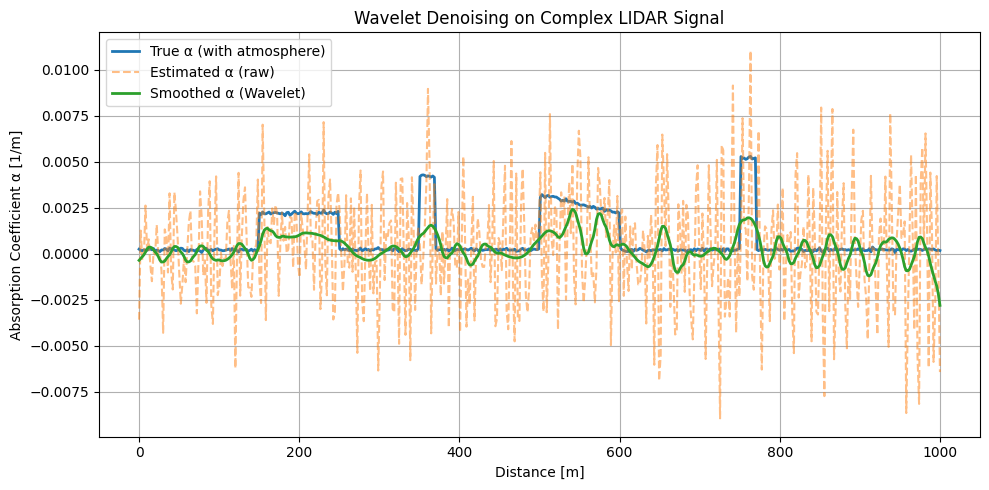

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load the complex simulated signal
df = pd.read_csv("simulated_dial_absorption_complex.csv")

# Handle NaNs (due to log/gradient instability)
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Apply Wavelet Denoising ---
def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # robust estimate of noise
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]
    return pywt.waverec(coeffs_thresh, wavelet)

df['Estimated_alpha_smooth'] = wavelet_denoise(df['Estimated_alpha'])

# Trim if necessary (due to wavelet reconstruction length)
df = df[:len(df['Estimated_alpha_smooth'])]

# Save result
df.to_csv("filtered_wavelet_complex.csv", index=False)
print("✅ Filtered data saved to: filtered_wavelet_complex.csv")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Distance_m'], df['True_alpha_with_atmosphere'], label='True α (with atmosphere)', linewidth=2)
plt.plot(df['Distance_m'], df['Estimated_alpha'], label='Estimated α (raw)', linestyle='--', alpha=0.5)
plt.plot(df['Distance_m'], df['Estimated_alpha_smooth'], label='Smoothed α (Wavelet)', linewidth=2)
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Wavelet Denoising on Complex LIDAR Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


spline filter

✅ Filtered data saved to: filtered_spline_complex.csv


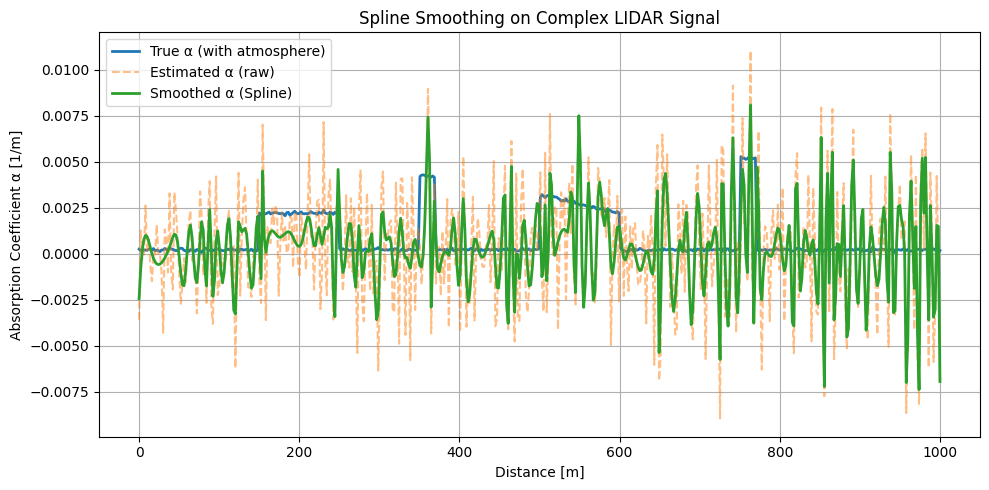

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Load the complex simulated signal
df = pd.read_csv("simulated_dial_absorption_complex.csv")

# Handle NaNs (from DIAL estimation)
df['Estimated_alpha'] = df['Estimated_alpha'].interpolate(method='linear', limit_direction='both')

# --- Apply Spline Smoothing ---
x = df['Distance_m'].values
y = df['Estimated_alpha'].values

# Fit a univariate spline with smoothing factor s (to control smoothness)
spline = UnivariateSpline(x, y, s=0.002)  # s can be tuned
df['Estimated_alpha_smooth'] = spline(x)

# Save result
df.to_csv("filtered_spline_complex.csv", index=False)
print("✅ Filtered data saved to: filtered_spline_complex.csv")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(x, df['True_alpha_with_atmosphere'], label='True α (with atmosphere)', linewidth=2)
plt.plot(x, y, label='Estimated α (raw)', linestyle='--', alpha=0.5)
plt.plot(x, df['Estimated_alpha_smooth'], label='Smoothed α (Spline)', linewidth=2)
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Spline Smoothing on Complex LIDAR Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Comparaisons des filtres

📊 Relative Error (Gas Region Only):
→ Moving Average:   Mean = 55.00%, Std = 19.30%
→ Savitzky-Golay:   Mean = 55.60%, Std = 27.80%
→ Wavelet:          Mean = 54.66%, Std = 18.91%
→ Spline:           Mean = 72.52%, Std = 53.28%


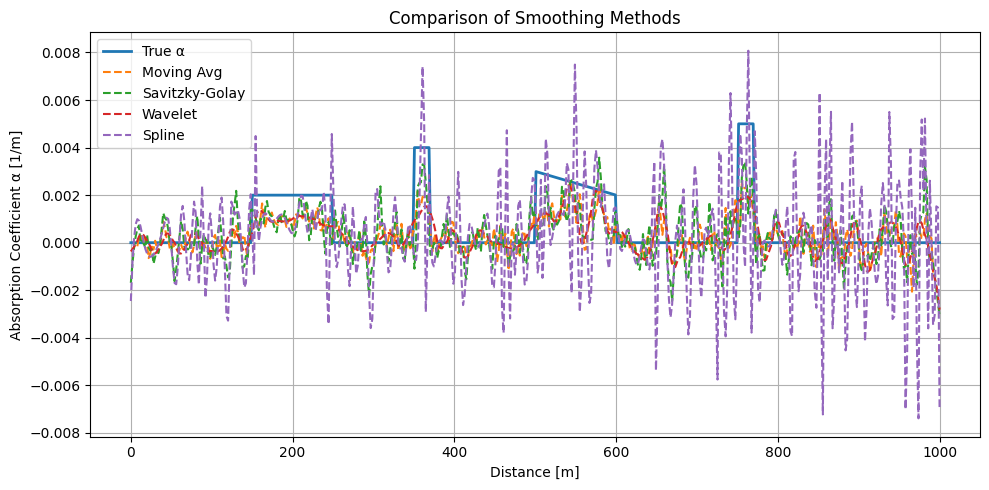

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load all filtered and reference files ---
raw = pd.read_csv("simulated_dial_absorption_complex.csv")
rolling = pd.read_csv("filtered_moving_average_complex.csv")
savgol = pd.read_csv("filtered_savgol_complex.csv")
wavelet = pd.read_csv("filtered_wavelet_complex.csv")
spline = pd.read_csv("filtered_spline_complex.csv")

# --- Define gas region where true absorption is non-zero ---
mask = raw["True_alpha"] > 0

true_alpha = raw["True_alpha"][mask]

# --- Compute relative errors ---
def relative_error(estimated_alpha):
    return np.abs((estimated_alpha[mask] - true_alpha) / true_alpha) * 100

err_rolling = relative_error(rolling["Estimated_alpha_smooth"])
err_savgol = relative_error(savgol["Estimated_alpha_smooth"])
err_wavelet = relative_error(wavelet["Estimated_alpha_smooth"])
err_spline = relative_error(spline["Estimated_alpha_smooth"])

# --- Display statistics ---
print("📊 Relative Error (Gas Region Only):")
print(f"→ Moving Average:   Mean = {np.mean(err_rolling):.2f}%, Std = {np.std(err_rolling):.2f}%")
print(f"→ Savitzky-Golay:   Mean = {np.mean(err_savgol):.2f}%, Std = {np.std(err_savgol):.2f}%")
print(f"→ Wavelet:          Mean = {np.mean(err_wavelet):.2f}%, Std = {np.std(err_wavelet):.2f}%")
print(f"→ Spline:           Mean = {np.mean(err_spline):.2f}%, Std = {np.std(err_spline):.2f}%")

# --- Plot comparison ---
plt.figure(figsize=(10, 5))
plt.plot(raw["Distance_m"], raw["True_alpha"], label="True α", linewidth=2)
plt.plot(rolling["Distance_m"], rolling["Estimated_alpha_smooth"], label="Moving Avg", linestyle="--")
plt.plot(savgol["Distance_m"], savgol["Estimated_alpha_smooth"], label="Savitzky-Golay", linestyle="--")
plt.plot(wavelet["Distance_m"], wavelet["Estimated_alpha_smooth"], label="Wavelet", linestyle="--")
plt.plot(spline["Distance_m"], spline["Estimated_alpha_smooth"], label="Spline", linestyle="--")
plt.xlabel("Distance [m]")
plt.ylabel("Absorption Coefficient α [1/m]")
plt.title("Comparison of Smoothing Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


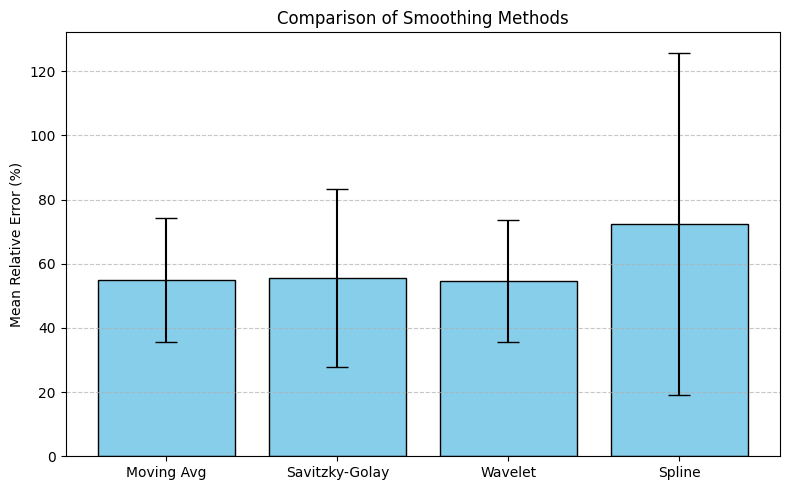

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load filtered and true data
raw = pd.read_csv("simulated_dial_absorption_complex.csv")
rolling = pd.read_csv("filtered_moving_average_complex.csv")
savgol = pd.read_csv("filtered_savgol_complex.csv")
wavelet = pd.read_csv("filtered_wavelet_complex.csv")
spline = pd.read_csv("filtered_spline_complex.csv")

# Mask for gas region
mask = raw["True_alpha"] > 0
true_alpha = raw["True_alpha"][mask]

# Compute relative errors
def compute_error(data):
    est = data["Estimated_alpha_smooth"][mask]
    return np.abs((est - true_alpha) / true_alpha) * 100

errors = {
    "Moving Avg": compute_error(rolling),
    "Savitzky-Golay": compute_error(savgol),
    "Wavelet": compute_error(wavelet),
    "Spline": compute_error(spline),
}

# Compute mean and std for each method
means = [np.mean(err) for err in errors.values()]
stds = [np.std(err) for err in errors.values()]
methods = list(errors.keys())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, means, yerr=stds, capsize=8, color='skyblue', edgecolor='black')
plt.ylabel("Mean Relative Error (%)")
plt.title("Comparison of Smoothing Methods")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Observations :

For this complex signal with discontinuities and realistic noise, wavelet filtering provides the best trade-off between accuracy and robustness, while splines should be avoided in this context.
Simple filters such as moving average or Savitzky-Golay remain acceptable, but are less effective when dealing with non-smooth signals.